# **Preface** 

Maintenance of equipment is a critical activity for any business involving machines. Predictive maintenance is the method of scheduling maintenance based on the prediction about the failure time of any equipment. The machine learning models is constructed based on the datasets from turbo fan engine data from the Prognostics Data Repository of NASA. Using a training set, a model was constructed and was verified with a test data set. The results obtained were compared with the actual results to calculate the accuracy and the algorithm that results in maximum accuracy is identified. We have selected two machine learning algorithms for comparing the prediction accuracy.

In [1]:
# Importing required libraries 

import math
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

# **Data**

Our data includes data of 100 engines, each doing their respective number of cycles as per their functional lifecycle. During each cycle the sensors installed collects the data in each respective cycle. Based on this collected data we need to build a model which would predict the remaining useful life(**RUL**, time before which engine goes for maintenance to avoid unexpected breakdown) of a already/newly installed engine based on its current cycle data.  

In [2]:
#Importing data files

jet_data = pd.read_csv(r"D:\AKSHAY\study\python\Project\CMaps\train_FD001.txt", sep=" ", header=None)
jet_rul = pd.read_csv(r"D:\AKSHAY\study\python\Project\CMaps\RUL_FD001.txt", sep=" ", header=None)
test_data = pd.read_csv(r"D:\AKSHAY\study\python\Project\CMaps\test_FD001.txt", sep = "\s+", header = None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
test_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_rul.columns = ['cycles', 'id']
jet_rul['id'] = jet_data['id'].unique()
jet_rul.set_index('id', inplace=True)

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

# **Data Manipulation**

The test data does not have RUL column so for model validation purposes we will add the column externally in the dataframe

In [3]:
#adding RUL column to the data
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"] 
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [4]:
#Preliminary analysis of data to understand the number of parameters and basic statistics
jet_data.describe()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


In [5]:
#checking the RUL data values 
jet_data.shape

(20631, 27)

# **Visualizing Data**

We will visualize the data to determine the relevance of data and figure out the model determining attributes

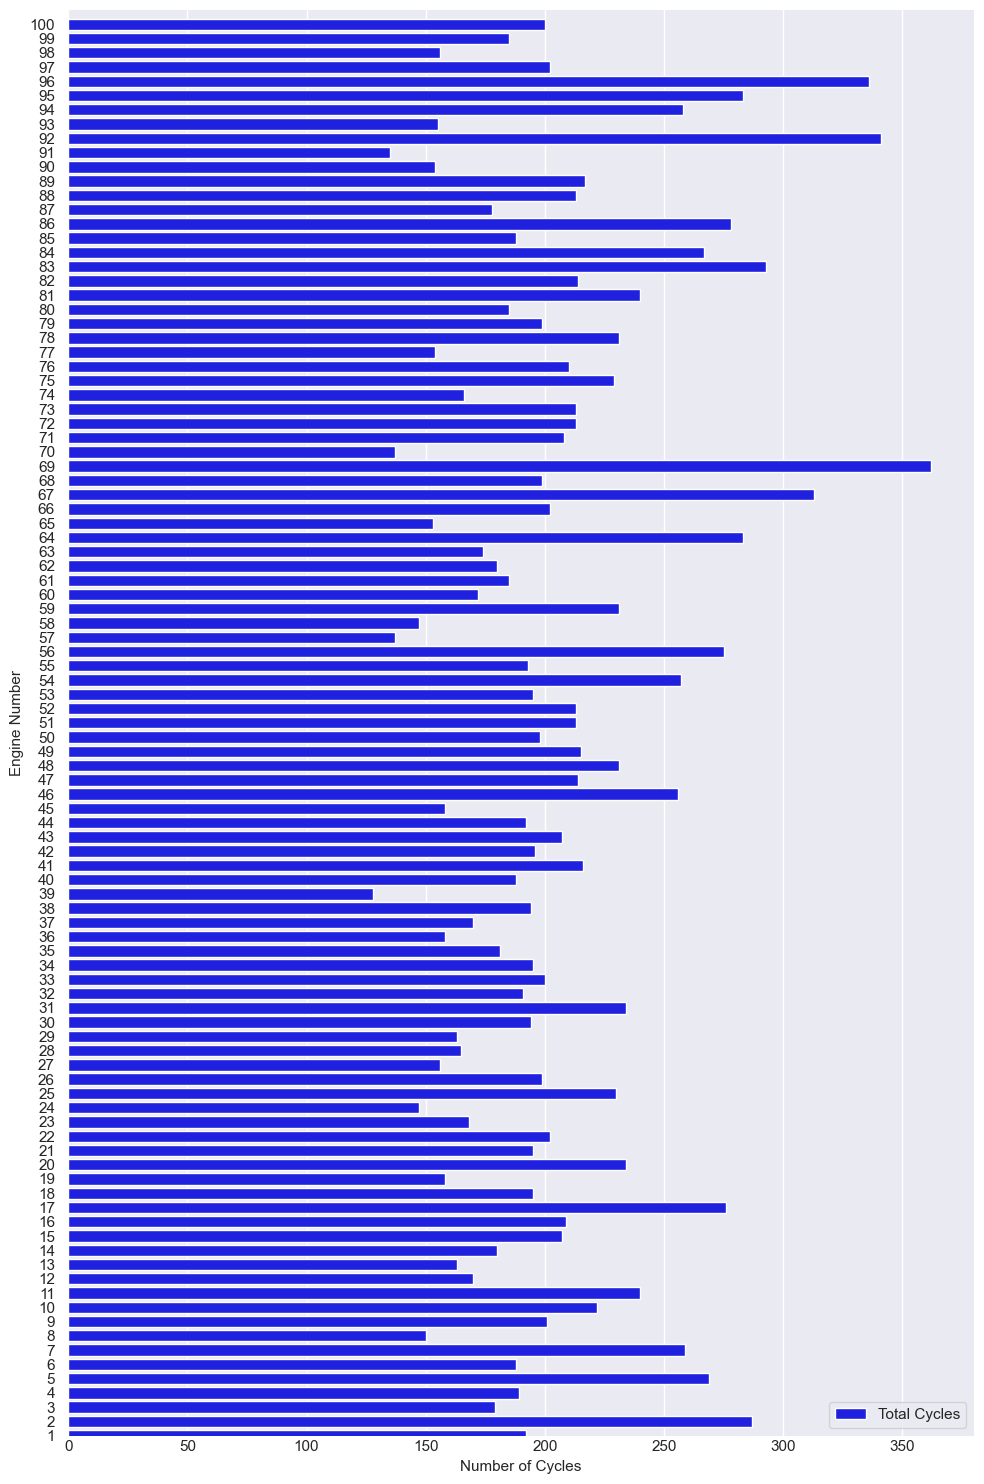

In [6]:
# Visualize total number of cycles by each engine

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

### Observations:
By observing above visualization we get to know that the number of cycles runned by the each engine before failing.

Mean number of cycles after which jet engine fails is 206


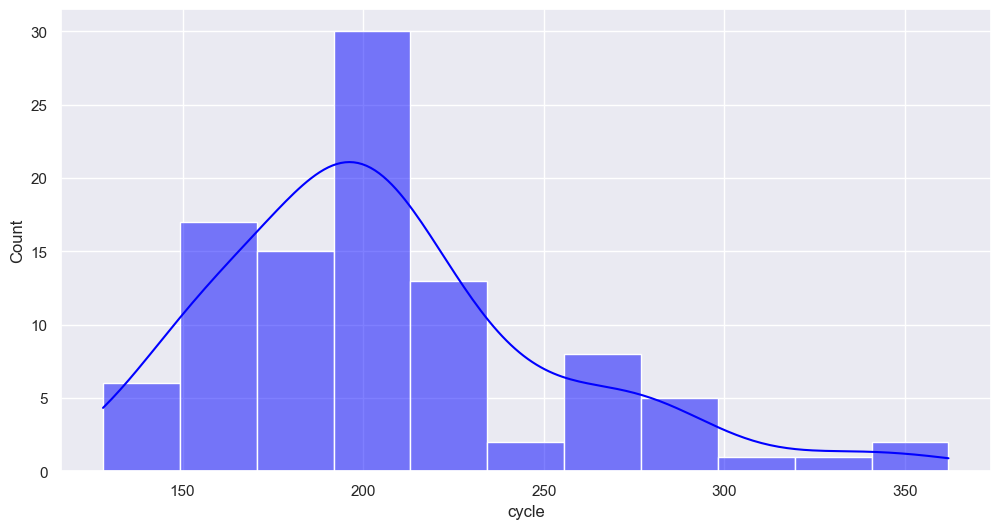

In [7]:
# Determining mean number of cycles and histogram of number of cycle

plt.subplots(figsize=(12, 6))
sns.histplot(jet_id_and_rul["cycle"], kde = True, color='blue');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(jet_id_and_rul["cycle"].mean())))

### Observations:
    By seeing above graph we can observe that Mean number of cycles after which jet engine fails is 206

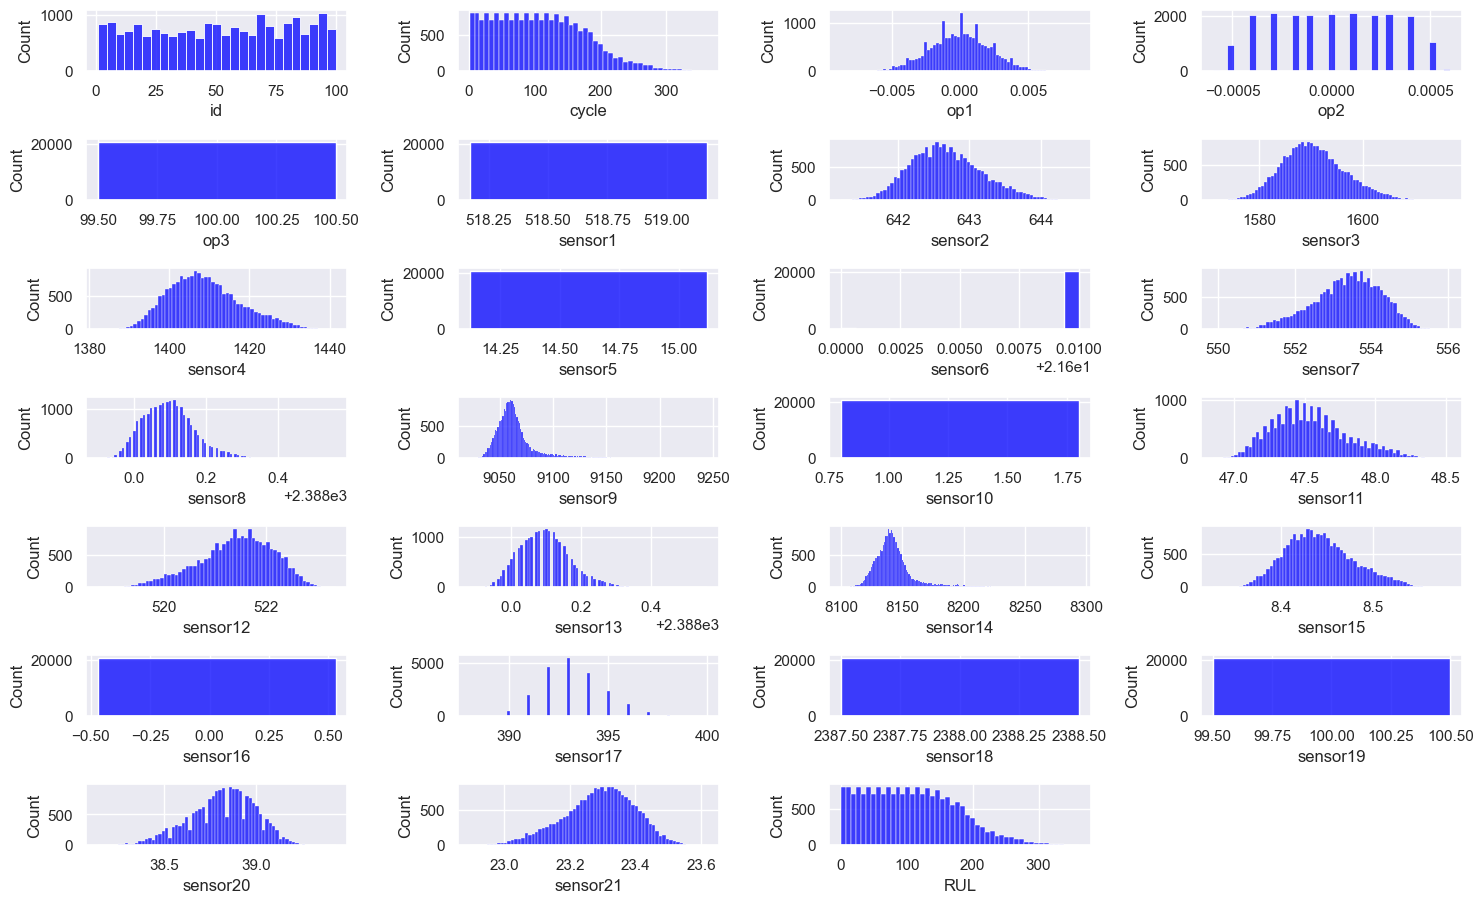

In [8]:
#Histogram representation of each sensor data

sns.set()
fig = plt.figure(figsize = [15,10])
cols = jet_data.columns
cnt = 1
for col in cols :
    plt.subplot(8,4,cnt)
    sns.histplot(jet_data[col],color='blue')
    cnt+=1
plt.tight_layout()
plt.show() 

### **Observations:**
As we could see there are many sensor data which aren't following the normal distribution, we will tend to ignore those sensors for our model training. We would try to reduce the curse of dimensionality by doing so. 

# **Correlation Matrix**

To see wheather the selected attributes are not related to each other. This way we will be able to reduce some more attributes, making our model free from overfitting. 

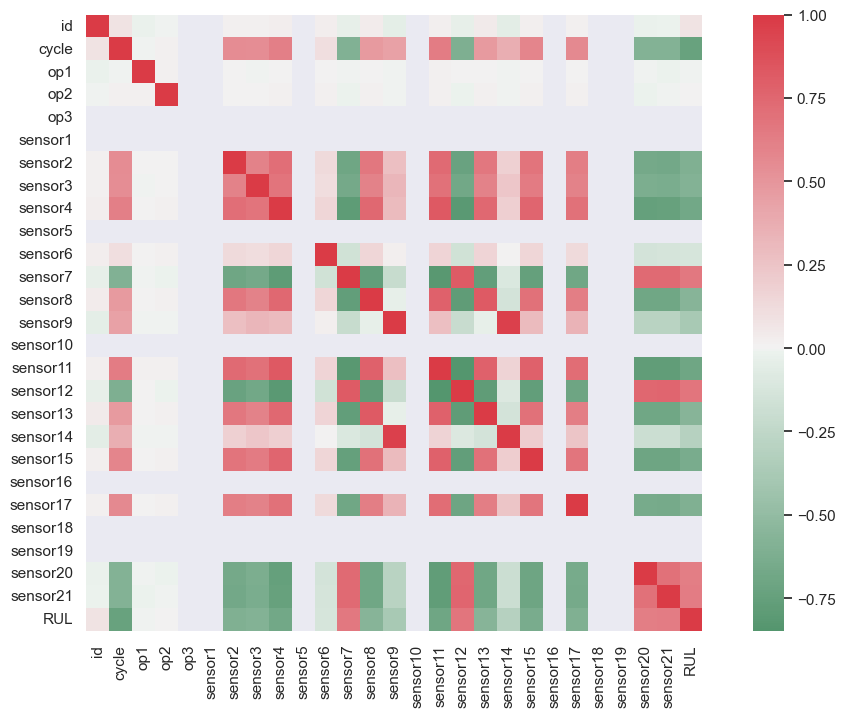

In [9]:
#Creating a heatmap to compare with RUL

plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

## Deletion of non contributing parameters into the analysis

Using the above correlation heatmap, We can safely ignore the parameters with lesser correlation with RUL. we can infer that the following parameters are not related to the RUL. 
* id, op1, op2, op3
* sensor1, sensor5, sensor6, sensor10
* sensor16, sensor18, sensor19

In [10]:
#New Dataframe with relevant parameters

jet_relevant_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19"], axis=1)

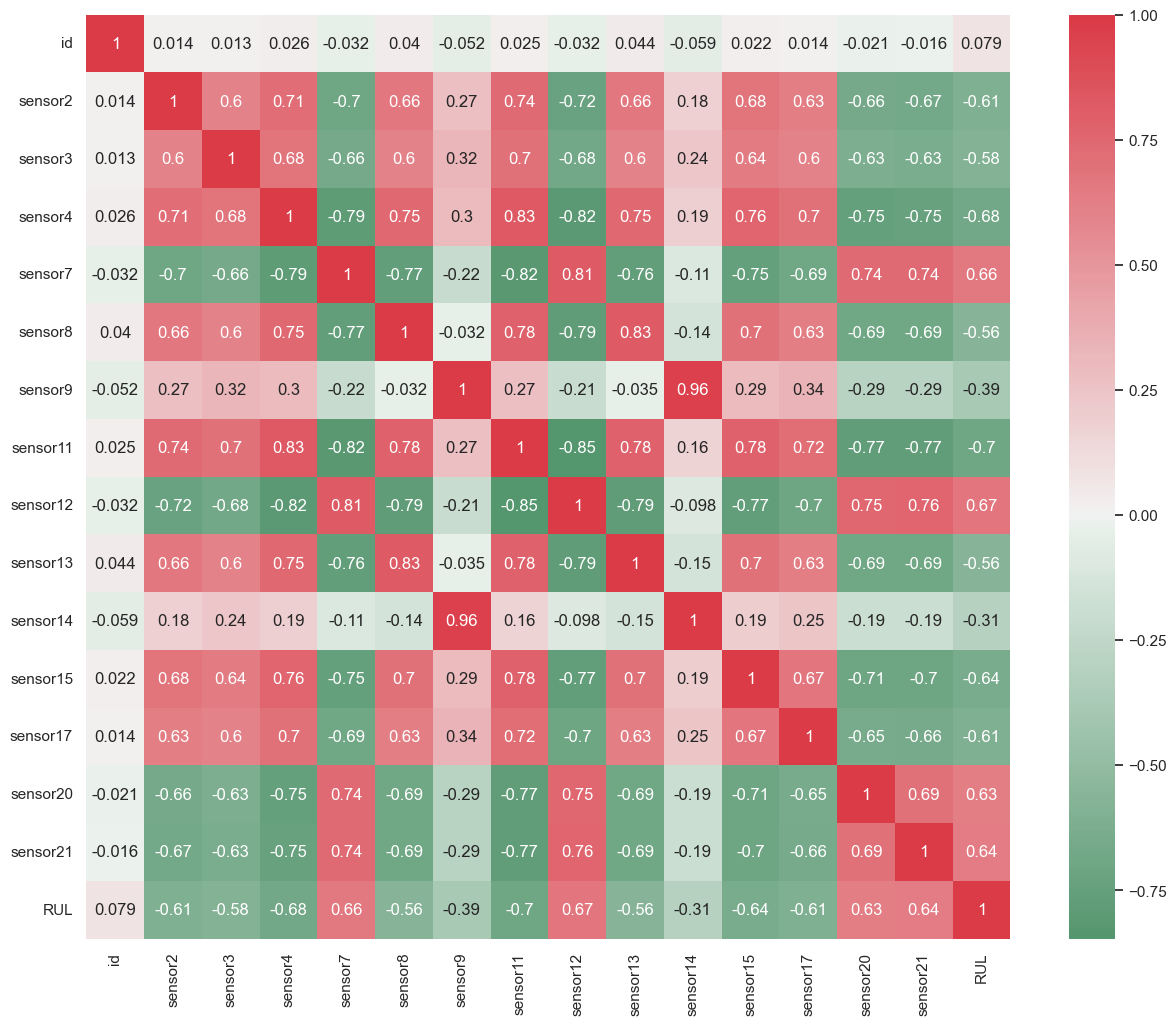

In [11]:
#Updated heatmap with relevant parameters

plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap =cmap, center=0, annot=True, square=True);

In [12]:
def plot_sensor(sensor_name,X):
    plt.figure(figsize=(13,5))
    for i in X['id'].unique():
        if (i % 10 == 0):  # only plot every engine
            plt.plot('RUL', sensor_name, 
                     data=X[X['id']==i].rolling(8).mean())
           # plt.axvline(30, color='red', linestyle='dashed', linewidth=2)
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

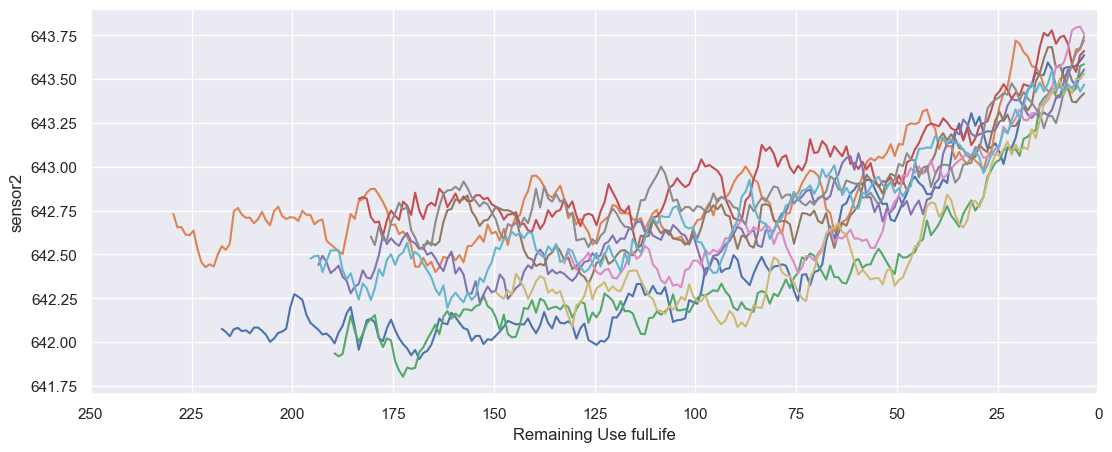

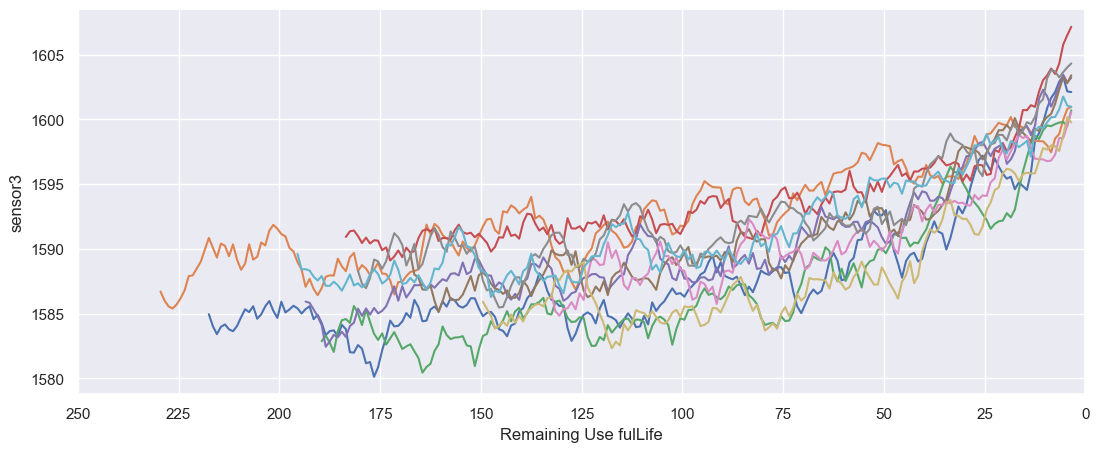

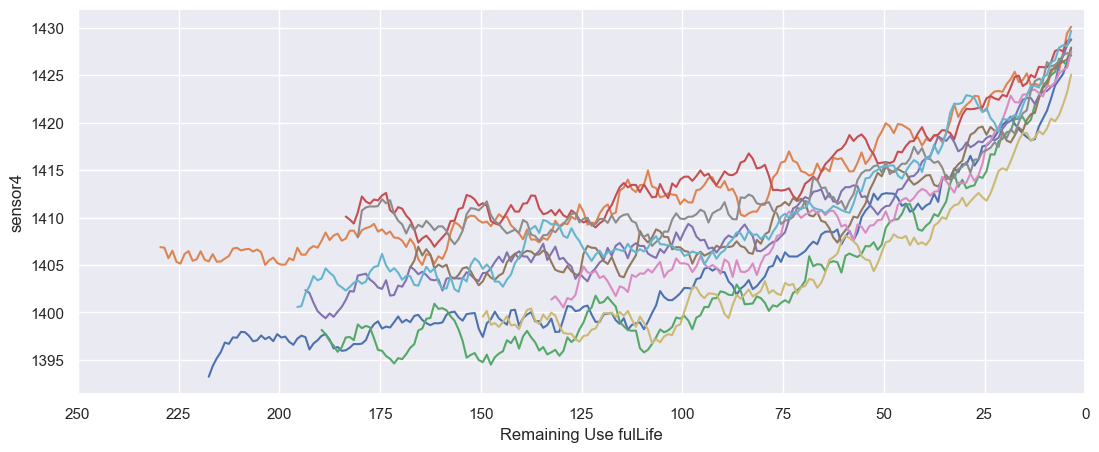

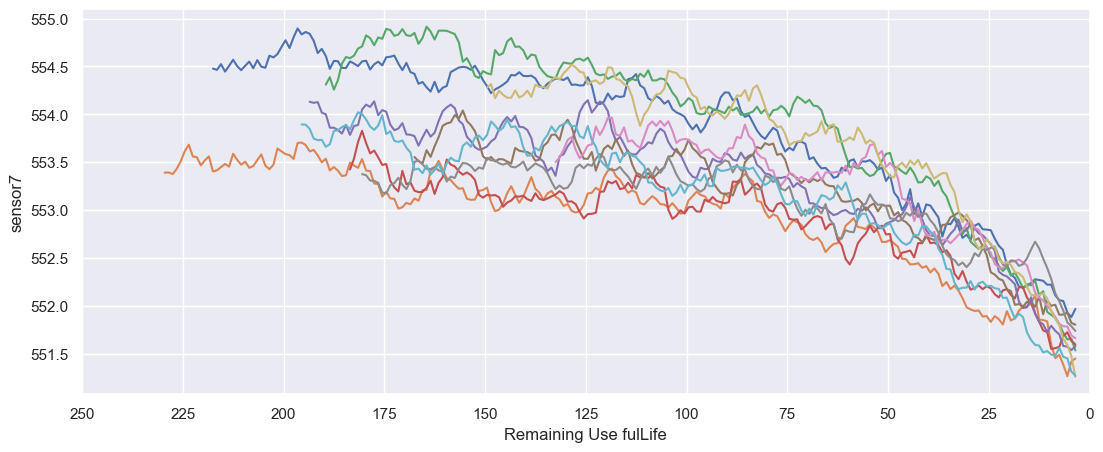

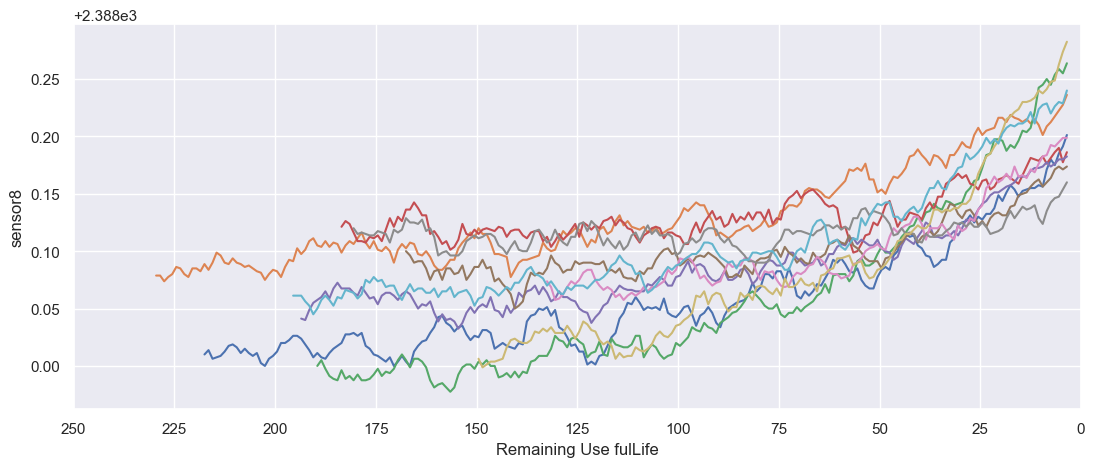

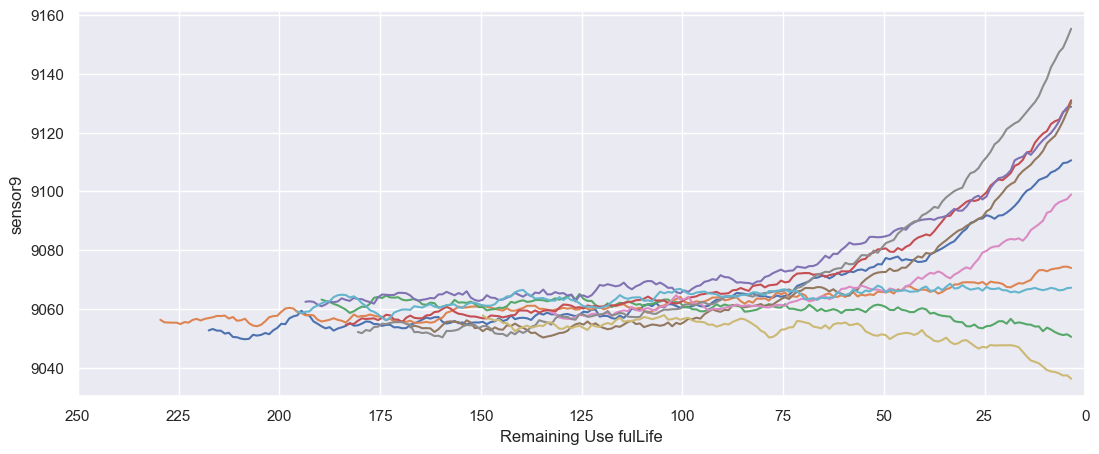

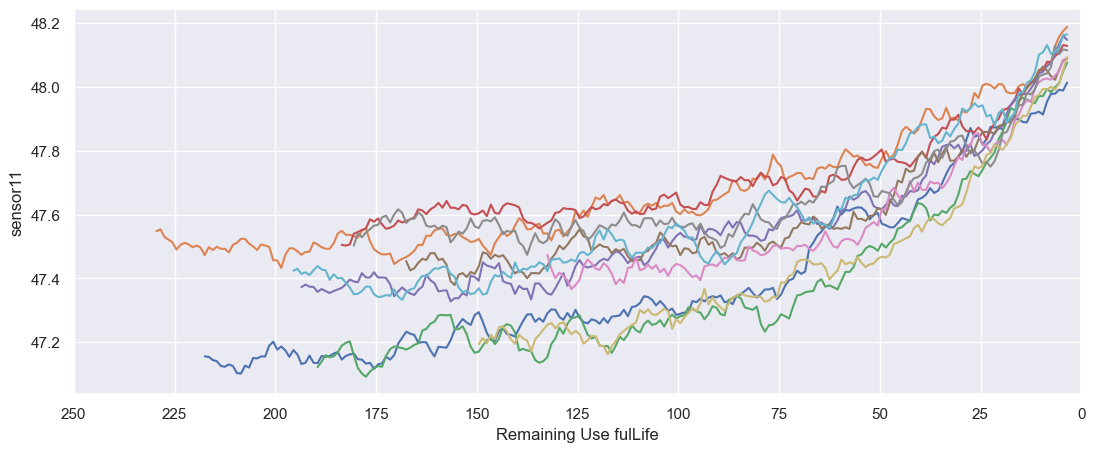

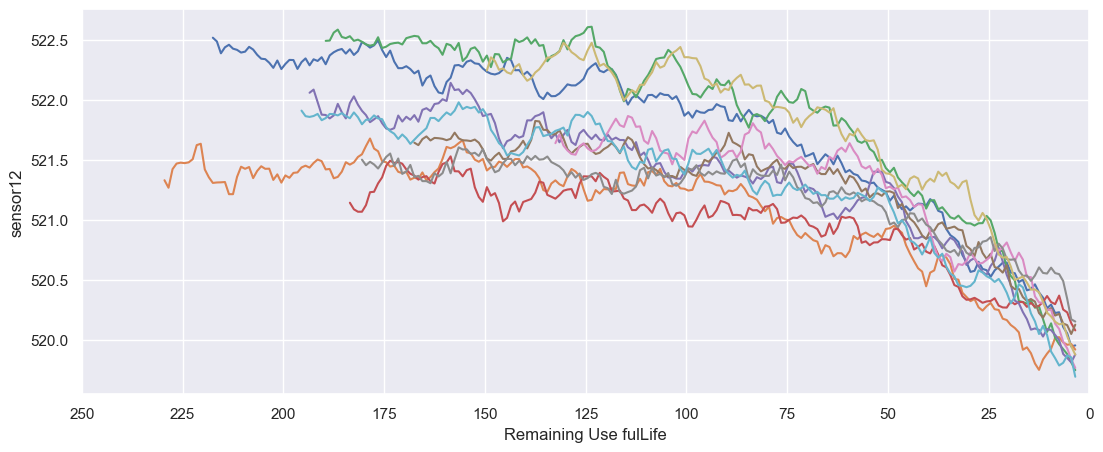

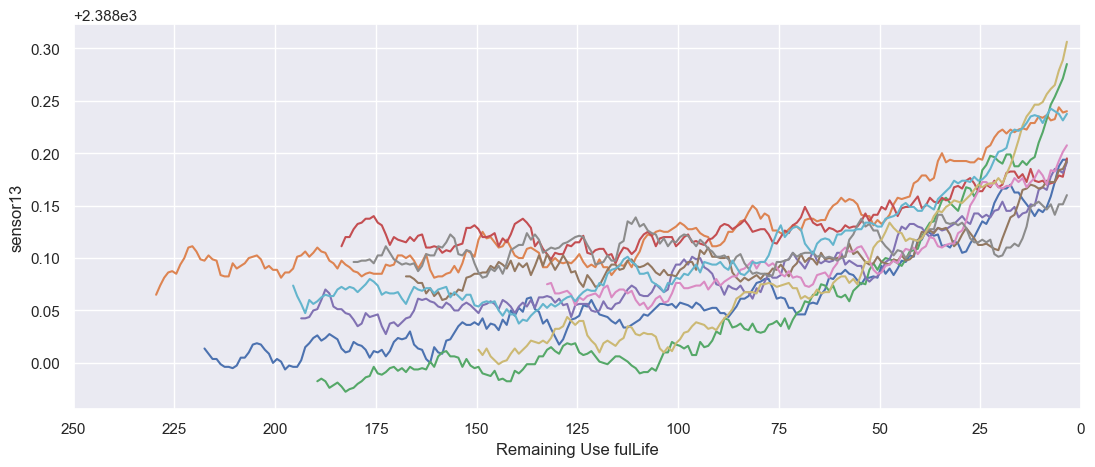

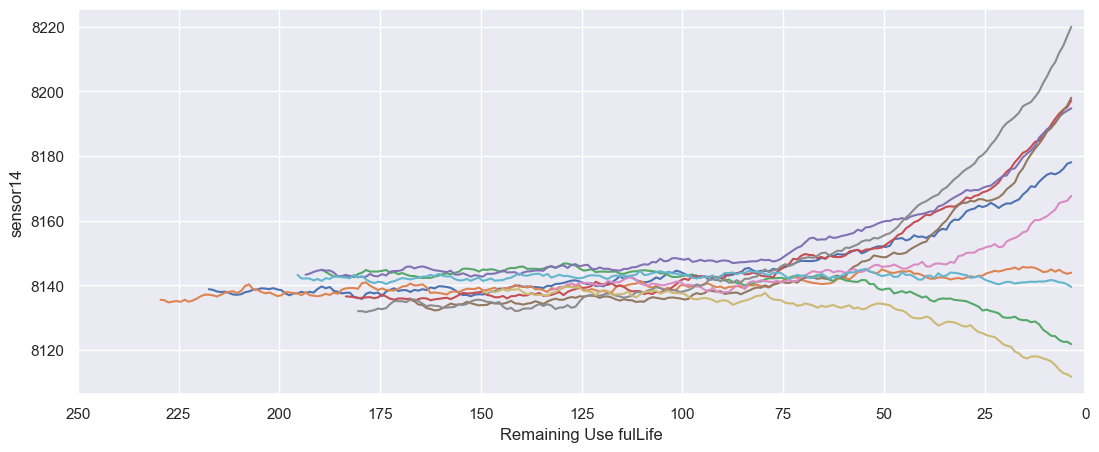

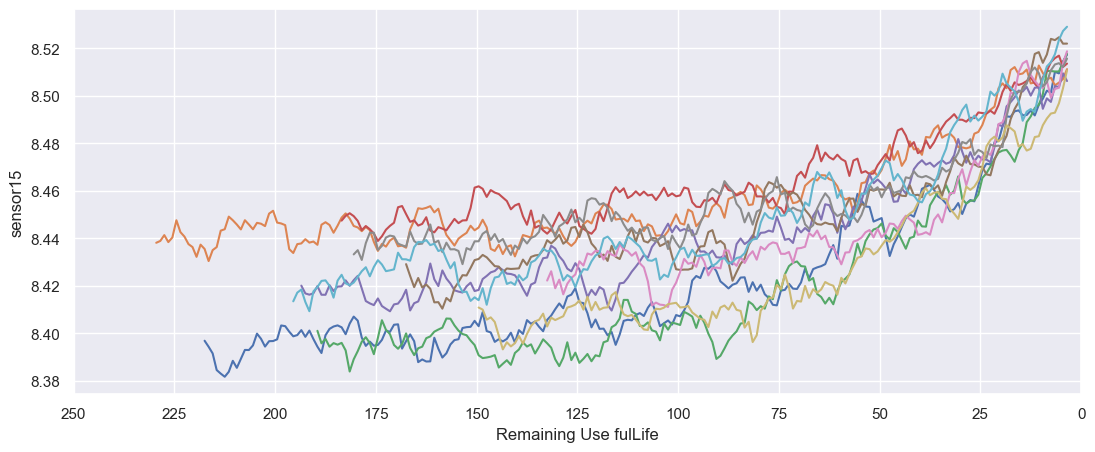

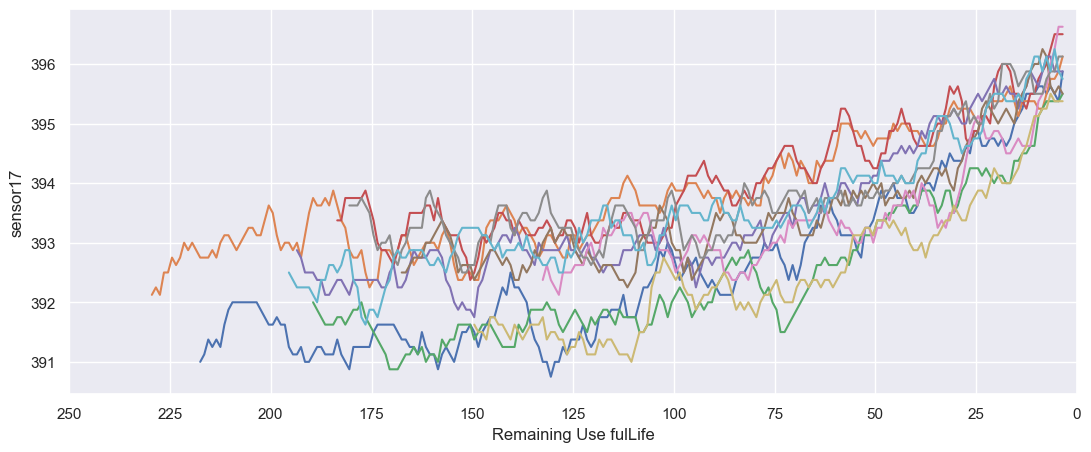

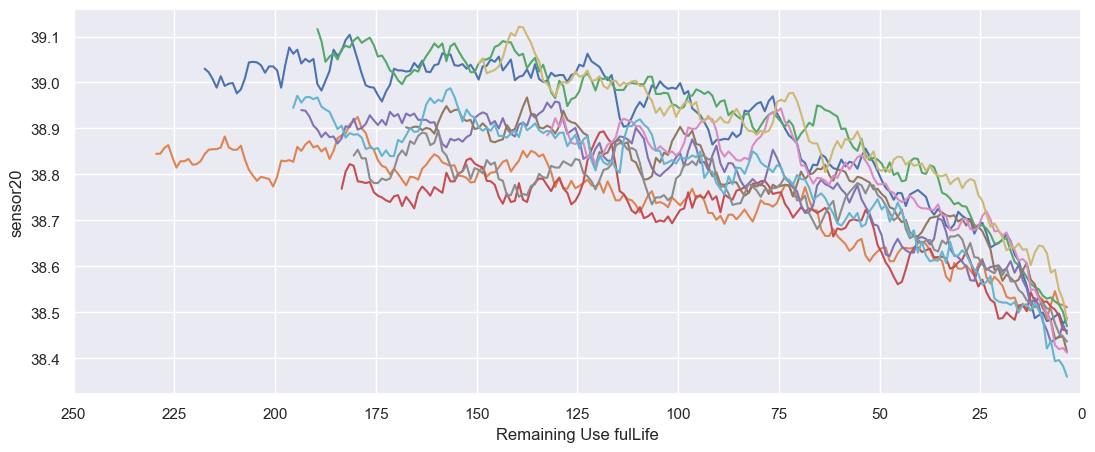

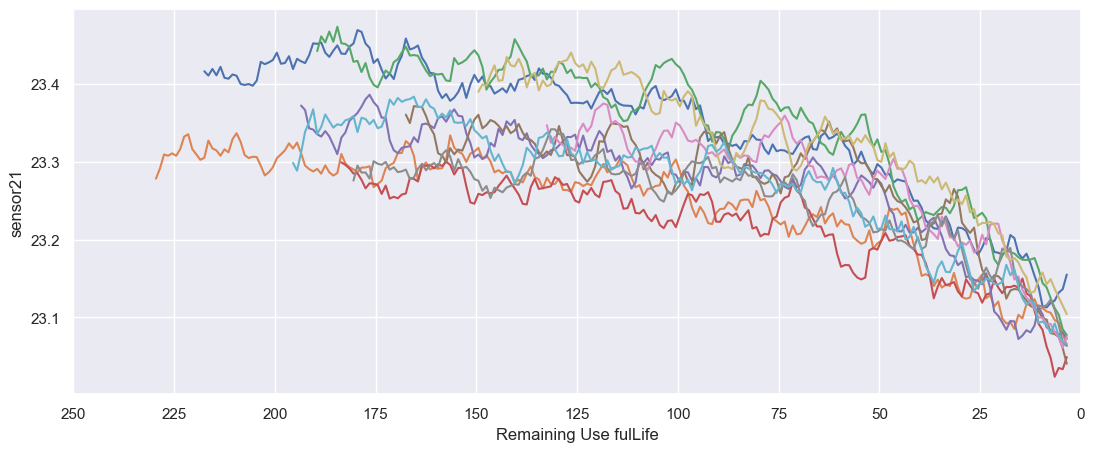

In [13]:
for sensor in jet_relevant_data.drop(['id', 'RUL'], axis=1).columns:
    plot_sensor(sensor, jet_relevant_data)

In [14]:
# Scaling

In [15]:
scaler = MinMaxScaler()
scaler.fit(jet_relevant_data.drop(['id', 'RUL'], axis=1))
scaled_features = scaler.transform(jet_relevant_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=jet_relevant_data.drop(['id', 'RUL'], axis=1).columns)

In [16]:
file = open('scaler_transformation.pkl', 'wb')
joblib.dump(scaler,file)
file.close()

In [17]:
scaled_features['id'] = jet_relevant_data['id']
scaled_features['RUL'] = jet_relevant_data['RUL']

In [18]:
scaled_features.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,id,RUL
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,1,191
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,1,190
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,1,189
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,1,188
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,1,187


In [19]:
data = scaled_features.copy()

In [20]:
data.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,id,RUL
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,1,191
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,1,190
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,1,189
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,1,188
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,1,187


In [21]:
# Data splitting for Train & Test 

In [22]:
y = data['RUL']
X = data.drop(['RUL', 'id'], axis=1)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 14)
X_test shape :  (4127, 14)
y_train shape :  (16504,)
y_test shape :  (4127,)


# Machine learning models

#### creating a base model from linear regression for refrence

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

ref_model = LinearRegression()
ref_model.fit(X_train,y_train)
y_pred_train = ref_model.predict(X_train)

print("Train r2 score",round(r2_score(y_pred_train,y_train),3))
print("Train mean square error",round(mean_squared_error(y_pred_train,y_train),))


#predict using cross validation data
y_pred_test = ref_model.predict(X_test)
print("===================================================")
print("Test r2 score",round(r2_score(y_pred_test,y_test),3))
print("Test mean square error",round(mean_squared_error(y_pred_test,y_test),3))

Train r2 score 0.275
Train mean square error 1998
Test r2 score 0.266
Test mean square error 1987.286


## Model-1(SGD regression with hyperparamter tuning)

In [25]:
from sklearn.linear_model import SGDRegressor

alpha = [10**i for i in range(-4,4)]

param = {'alpha':alpha,'penalty':['l1','l2'] }
lr_reg  = SGDRegressor(random_state=42)
lr_gsv =GridSearchCV(lr_reg,param,scoring= 'r2',cv =5, n_jobs= -1,return_train_score=True)

lr_gsv.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=SGDRegressor(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='r2')

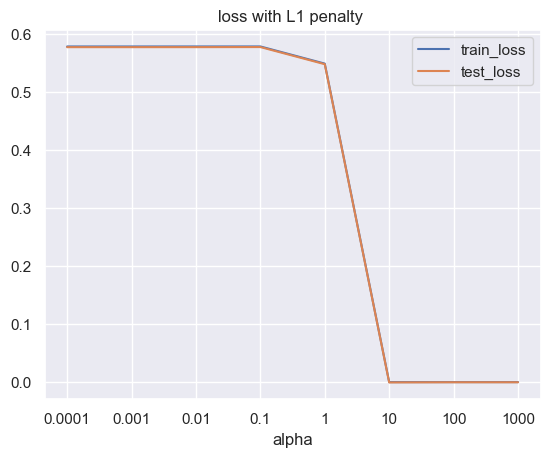

In [26]:
# ploting the loss with l1 regularization
train_score= lr_gsv.cv_results_['mean_train_score'][::2]
CV_score = lr_gsv.cv_results_['mean_test_score'][::2]

plt.plot(range(0,8),train_score,label = 'train_loss')
plt.plot(range(0,8),CV_score,label = 'test_loss')
plt.legend()
plt.xlabel("alpha")
plt.xticks(range(0,8),alpha)
plt.title("loss with L1 penalty ")
plt.show()

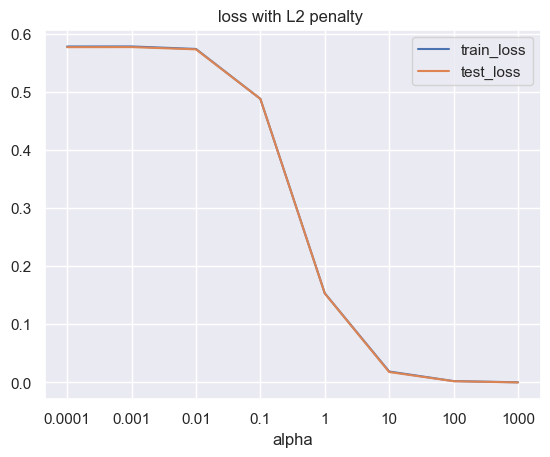

In [27]:
# ploting the loss with l2 regularization
train_score= lr_gsv.cv_results_['mean_train_score'][1:16:2]
CV_score = lr_gsv.cv_results_['mean_test_score'][1:16:2]

plt.plot(range(0,8),train_score,label = 'train_loss')
plt.plot(range(0,8),CV_score,label = 'test_loss')
plt.legend()
plt.xlabel("alpha")
plt.xticks(range(0,8),alpha)
plt.title("loss with L2 penalty ")
plt.show()

In [28]:
print("Best parameters:",lr_gsv.best_params_)
print("Best score: ",lr_gsv.best_score_)

Best parameters: {'alpha': 0.1, 'penalty': 'l1'}
Best score:  0.5768053484342875


In [29]:
# train model on best parameter
lr_reg  =SGDRegressor(random_state=42,alpha =  0.01, penalty = 'l1')
lr_reg.fit(X_train,y_train)

pred_train = lr_reg.predict(X_train)
score_tr = r2_score(y_train,pred_train)

print("r2 score for train set with best model:",round(score_tr,3))

pred = lr_reg.predict(X_test)
score = r2_score(y_test,pred)

print("r2 score for test set wiht best model:",round(score,3))

r2 score for train set with best model: 0.578
r2 score for test set wiht best model: 0.577


## observations:

compare to the reference model,SGD regressor has given good results

## SVM(Regression)

In [30]:
%%time
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
from sklearn.metrics import r2_score
alpha = [10**i for i in range(-4,4)]
para = {'kernel':['linear','rbf'],'C':alpha,
        'gamma': [1, 0.1, 0.01]}  

svm_reg = SVR()
svm_gsv = RandomizedSearchCV(svm_reg,para,scoring = 'r2',cv=5)
svm_gsv.fit(X_train,y_train)

print("Best parameters:",svm_gsv.best_params_)
print("Best score: ",svm_gsv.best_score_)

Best parameters: {'kernel': 'rbf', 'gamma': 1, 'C': 1000}
Best score:  0.6279388937760906
CPU times: total: 7min 53s
Wall time: 7min 53s


In [31]:
# train the svr with the best parameters
svm_reg = SVR(kernel= 'linear', gamma=0.1, C = 1)
svm_reg.fit(X_train,y_train)

pred_train = lr_reg.predict(X_train)
score_tr = r2_score(y_train,pred_train)

print("r2 score for train set with best model:",round(score_tr,3))

pred = lr_reg.predict(X_test)
score = r2_score(y_test,pred)

print("r2 score for cv set wiht best model:",round(score,3))

r2 score for train set with best model: 0.578
r2 score for cv set wiht best model: 0.577


## Decision tree

In [32]:
from sklearn.tree import DecisionTreeRegressor
para = {'max_features':['auto', 'sqrt', 'log2'],
        'max_depth':[ 5, 10,12,15,20,25,30],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1,5,8,10,20,30] }


df_reg = DecisionTreeRegressor(random_state= 1)
df_rsv = RandomizedSearchCV(df_reg,para,scoring='neg_mean_squared_error',cv =5,n_iter=20)
df_rsv.fit(X_train,y_train)

print(df_rsv.best_params_)


{'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 5}


In [33]:
# train the model with best parameter

dt_best  = DecisionTreeRegressor(min_samples_split= 3, min_samples_leaf= 8 ,max_features= 'auto', max_depth= 5,random_state= 42)
dt_best.fit(X_train,y_train)

pred_train = dt_best.predict(X_train)
print("R2 score for best model for train data",r2_score(y_train,pred_train).round(3))

pred_cv = dt_best.predict(X_test)
print("R2 score for best model for cv data",r2_score(y_test,pred_cv).round(3))

R2 score for best model for train data 0.589
R2 score for best model for cv data 0.581


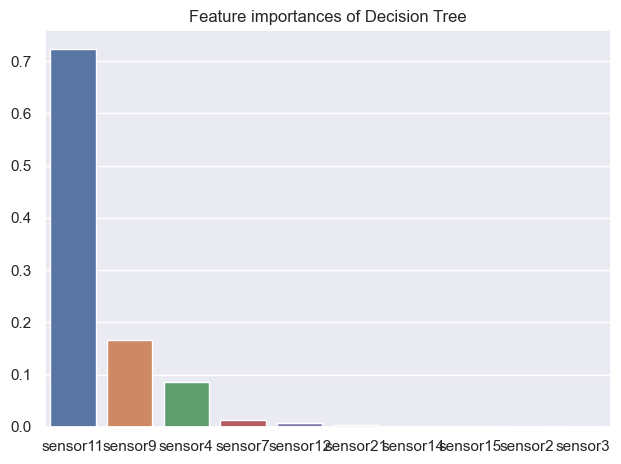

In [34]:
import seaborn as sns
importace= dt_best.feature_importances_
feature_names= dt_best.feature_names_in_
forest_importances = pd.Series(importace, index=feature_names)
a = forest_importances.sort_values(ascending=False)[0:10]


#plt.figure(figsize =(8,10))
sns.barplot(x = a.index,y = a.values)
plt.title("Feature importances of Decision Tree")
plt.tight_layout()

## Random forest regressor

In [35]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
para = { 'n_estimators' :[5,10,15,20,50,100,200,500,1000],
        'max_features':['auto', 'sqrt', 'log2'],
        'max_depth':[ 5, 10,12,15,20,25,30],
        'min_samples_split': [2, 3, 5],
        'min_samples_leaf': [1,5,8,10,20,30] }



rf_reg = RandomForestRegressor(random_state= 42)
rf_rsv = RandomizedSearchCV(rf_reg,para,scoring='neg_mean_squared_error',cv =5,n_iter=30)
rf_rsv.fit(X_train,y_train)

print(rf_rsv.best_params_)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 30}
CPU times: total: 7min 22s
Wall time: 7min 23s


In [36]:
# train the random forest with best parameters

rf_best = RandomForestRegressor(n_estimators= 200, min_samples_split= 5, min_samples_leaf=5, max_features='auto', max_depth= 5,random_state= 42)
rf_best.fit(X_train,y_train)


pred_train = dt_best.predict(X_train)
print("R2 score for best model for train data",r2_score(y_train,pred_train).round(3))

pred_cv = dt_best.predict(X_test)
print("R2 score for best model for test data",r2_score(y_test,pred_cv).round(3))

R2 score for best model for train data 0.589
R2 score for best model for test data 0.581


## XGboost model

In [37]:
%%time 
from xgboost import XGBRegressor


# A parameter grid for XGBoost
params = {
    'n_estimators':[10,20,30,50,100,200,500], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

reg = XGBRegressor(nthread=-1,random_state = 1)

# run randomized search
n_iter_search = 10
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='r2')

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 31.97 seconds for 10 candidates parameter settings.
CPU times: total: 7min 43s
Wall time: 32.4 s


In [38]:
best_regressor_xgb = random_search.best_estimator_
best_regressor_xgb

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False, eta=0.3,
             eval_metric='rmse', gamma=0.4, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=-1,
             nthread=-1, num_parallel_tree=1, objective='reg:tweedie',
             predictor='auto', ...)

In [39]:
#saving the best xgboost regression model in a pickle file
import joblib
file = open('xbg_best.pkl', 'wb')
joblib.dump(best_regressor_xgb,file)

file.close()

In [40]:
# Get predictions
y_pred_train = best_regressor_xgb.predict(X_train)
r2score = r2_score(y_train, y_pred_train).round(3)
print("R2 score after train with best parameters for trainset:" ,r2score )

y_pred_test = best_regressor_xgb.predict(X_test)
r2score = r2_score(y_test, y_pred_test).round(3)
print("R2 score after train with best parameters for Test set:" ,r2score )

R2 score after train with best parameters for trainset: 0.676
R2 score after train with best parameters for Test set: 0.636


In [50]:
from prettytable import PrettyTable
pt = PrettyTable(hrules = True,vrules=True)

pt.field_names = ["SL NO", "Model", "Hyperparamter", "Train R2 score","Test R2 score"]
pt.add_rows([
["1", "Linear Regression,\n (Base model)","Nil",0.275,0.266 ],
["2", "SGD REgression","alpha =  0.01, penalty = 'l1' ",0.578,0.577],
["3", "SVM(Regression)","'kernel': 'linear', 'gamma': 0.1, 'C': 1",0.578,0.577],
["4", "Decision Tree","'min_samples_split': 3, 'min_samples_leaf': 8, \n 'max_features': 'auto', 'max_depth': 5",0.589,0.581 ],
["5", "Random Forest","n_estimators= 200, min_samples_split= 5,\n min_samples_leaf=5, max_features='auto', max_depth= 5",0.589,0.581 ],
["6", "Xg boost","colsample_bytree=0.9, eta=0.3, eval_metric='rmse',\n  gamma=0.4,max_depth=2, n_estimators=200,\n  nthread=-1, objective='reg:tweedie',subsample=0.8",0.676,0.636 ]])
 
print(pt)

+-------+--------------------+--------------------------------------------------------+----------------+---------------+
| SL NO |       Model        |                     Hyperparamter                      | Train R2 score | Test R2 score |
+-------+--------------------+--------------------------------------------------------+----------------+---------------+
|   1   | Linear Regression, |                          Nil                           |     0.275      |     0.266     |
|       |    (Base model)    |                                                        |                |               |
+-------+--------------------+--------------------------------------------------------+----------------+---------------+
|   2   |   SGD REgression   |             alpha =  0.01, penalty = 'l1'              |     0.578      |     0.577     |
+-------+--------------------+--------------------------------------------------------+----------------+---------------+
|   3   |  SVM(Regression)   |  

# Summary

### By training with the above all models, XGboost regressor model is performing best, so i choose the xgboost model for further testing and final predictions

In [42]:
import pickle

In [43]:
import joblib
file = open('xbg_best.pkl', 'wb')
joblib.dump(best_regressor_xgb,file)

file.close()

In [44]:
test_mod = joblib.load('xbg_best.pkl')

In [99]:
test_mod.predict(scaled_features[0:3])

array([174.34807, 158.42705, 157.71469], dtype=float32)